In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix

import mlflow
import mlflow.sklearn
from sqlalchemy.dialects.postgresql import array

In [2]:
data_path = "data/creditcard.csv"
df = pd.read_csv(data_path)
df = df.drop("Time", axis=1)

In [3]:
normal = df[df.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]

In [4]:
print(f"Normal : {normal.shape}")
print(f"anomaly : {anomaly.shape}")

Normal : (142158, 30)
anomaly : (492, 30)


In [5]:
normal_train, normal_test = train_test_split(normal, test_size=0.2, random_state=2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size=0.2, random_state=2020)

normal_train, normal_validate = train_test_split(normal_train, test_size=0.25, random_state=2020)
anomaly_train, anomaly_validate = train_test_split(anomaly_train, test_size=0.25, random_state=2020)

In [6]:
x_train = pd.concat((normal_train, anomaly_train))
x_test = pd.concat((normal_test, anomaly_test))
x_validate = pd.concat((normal_validate, anomaly_validate))

y_train = np.array(x_train["Class"])
y_test = np.array(x_test["Class"])
y_validate = np.array(x_validate["Class"])

x_train = x_train.drop("Class", axis=1)
x_test = x_test.drop("Class", axis=1)
x_validate = x_validate.drop("Class", axis=1)

In [7]:
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop("Class", axis=1))

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_validate = scaler.transform(x_validate)

In [8]:
# mlflow에서 train_acc를 로깅하여 매 실행에서 이 값을 추적하도록 함

def train(sk_model, x_train, y_train):
    sk_model = sk_model.fit(x_train, y_train)
    train_acc = sk_model.score(x_train, y_train)

    mlflow.log_metric("train_acc", train_acc)
    print(f"Train Accuracy : {train_acc:.3%}")

In [9]:
# 위와 마찬가지로 eval_acc, auc_score 모두 로깅
# log_artifact()로 플롯도 저장할 수 있음

def evaluate(sk_model, x_test, y_test):
    eval_acc = sk_model.score(x_test, y_test)
    preds = sk_model.predict(x_test)
    auc_score = roc_auc_score(y_test, preds)

    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("auc_score", auc_score)
    print(f"Auc Score : {auc_score:.3%}")
    print(f"Eval Accuracy : {eval_acc:.3%}")

    roc_plot = plot_roc_curve(sk_model, x_test, y_test, name="scikit-learn ROC Curve")
    plt.savefig("sklearn_roc_plot.png")
    plt.show()
    plt.clf()

    conf_matrix = confusion_matrix(y_test, preds)
    ax = sns.heatmap(conf_matrix, annot=True, fmt="g")
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title("Confusion Matrix")
    plt.savefig("sklearn_conf_matrix.png")

    mlflow.log_artifact("sklearn_roc_plot.png")
    mlflow.log_artifact("sklearn_conf_matrix.png")

2022/03/11 12:31:09 INFO mlflow.tracking.fluent: Experiment with name 'scikit_learn_experiment' does not exist. Creating a new experiment.
2022/03/11 12:31:09 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Train Accuracy : 99.893%
Auc Score : 85.341%
Eval Accuracy : 99.874%


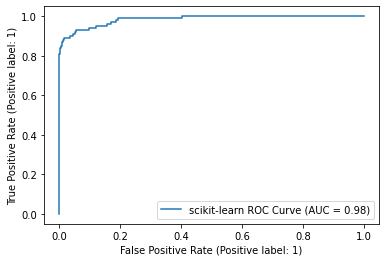

Model run : e54bcac3a2c74f03a1f9a0a67c5d1a02


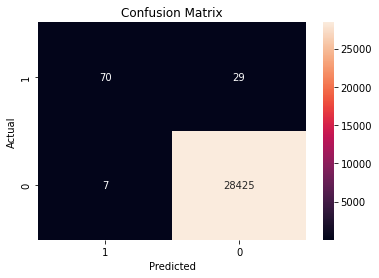

In [10]:
sk_model = LogisticRegression(random_state=None, max_iter=400, solver="newton-cg")

# 실험 이름 설정
mlflow.set_experiment("scikit_learn_experiment")

with mlflow.start_run():
    train(sk_model, x_train, y_train)
    evaluate(sk_model, x_test, y_test)
    mlflow.sklearn.log_model(sk_model, "log_reg_model")  # 저장할 모델과 이름
    print("Model run :", mlflow.active_run().info.run_uuid)  # 로깅되는 실행 출력

mlflow.end_run()  # 실행 종료

In [11]:
loaded_model = mlflow.sklearn.load_model("runs:/e54bcac3a2c74f03a1f9a0a67c5d1a02/log_reg_model")  # 포맷:/실행 ID/모델 이름

In [12]:
loaded_model.score(x_test, y_test)

0.9987382145736217

In [15]:
# 모델 적재 및 파라미터 튜닝

anomaly_weights = [1, 5, 10, 15]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)

In [16]:
# 10, 15일 때 가장 높았지만 이상 가중치가 증가할수록 상승 추세

mlflow.set_experiment("sklearn_creditcard_board_search")
logs = []

for f in range(len(anomaly_weights)):
    fold = 1
    accuracies = []
    auc_scores = []
    for train, test in kfold.split(x_validate, y_validate):

        with mlflow.start_run():
            weight = anomaly_weights[f]
            mlflow.log_param("anomaly_weight", weight)
            class_weights = {
                0:1,
                1:weight
            }

            sk_model = LogisticRegression(max_iter=400, solver="newton-cg", class_weight=class_weights).fit(x_validate[train], y_validate[train])

            print('-'*40)
            print(f"\nfold {fold}\nAnomaly Weight: {weight}")

            train_acc = sk_model.score(x_validate[train], y_validate[train])
            mlflow.log_metric("train_acc", train_acc)

            eval_acc = sk_model.score(x_validate[test], y_validate[test])
            preds = sk_model.predict(x_validate[test])
            mlflow.log_metric("eval_acc", eval_acc)

            try:
                auc_score = roc_auc_score(y_validate[test], preds)
            except:
                auc_score = -1

            mlflow.log_metric("auc_score", auc_score)
            print(f"AUC: {auc_score}\neval_acc: {eval_acc}")

            accuracies.append(eval_acc)
            auc_scores.append(auc_score)

            log = [sk_model, x_validate[test], y_validate[test], preds]
            logs.append(log)
            fold += 1
            mlflow.end_run()

    print("\nAverages : ")
    print("Accuracy :", np.mean(accuracies))
    print("AUC :", np.mean(auc_score))
    print("Best :")
    print("Accuracy :", np.max(accuracies))
    print("AUC :", np.max(auc_score))

----------------------------------------

fold 1
Anomaly Weight: 1
AUC: 0.8
eval_acc: 0.9985982127212195
----------------------------------------

fold 2
Anomaly Weight: 1
AUC: 0.8568790049001132
eval_acc: 0.998422712933754
----------------------------------------

fold 3
Anomaly Weight: 1
AUC: 0.8406451922461774
eval_acc: 0.9982474588152822
----------------------------------------

fold 4
Anomaly Weight: 1
AUC: 0.8682452129973255
eval_acc: 0.9987732211706976
----------------------------------------

fold 5
Anomaly Weight: 1
AUC: 0.8528532875621686
eval_acc: 0.9989484752891693

Averages : 
Accuracy : 0.9985980161860246
AUC : 0.8528532875621686
Best :
Accuracy : 0.9989484752891693
AUC : 0.8528532875621686
----------------------------------------

fold 1
Anomaly Weight: 5
AUC: 0.8748241603657465
eval_acc: 0.9987734361310671
----------------------------------------

fold 2
Anomaly Weight: 5
AUC: 0.975398919462244
eval_acc: 0.9982474588152822
----------------------------------------

fold 

In [17]:
# guided search

anomaly_weights = [10, 50, 100, 150, 200]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)

In [18]:
mlflow.set_experiment("sklearn_creditcard_guided_search")
logs = []

for f in range(len(anomaly_weights)):
    fold = 1
    accuracies = []
    auc_scores = []
    for train, test in kfold.split(x_validate, y_validate):

        with mlflow.start_run():
            weight = anomaly_weights[f]
            mlflow.log_param("anomaly_weight", weight)
            class_weights = {
                0:1,
                1:weight
            }

            sk_model = LogisticRegression(max_iter=400, solver="newton-cg", class_weight=class_weights).fit(x_validate[train], y_validate[train])

            print('-'*40)
            print(f"\nfold {fold}\nAnomaly Weight: {weight}")

            train_acc = sk_model.score(x_validate[train], y_validate[train])
            mlflow.log_metric("train_acc", train_acc)

            eval_acc = sk_model.score(x_validate[test], y_validate[test])
            preds = sk_model.predict(x_validate[test])
            mlflow.log_metric("eval_acc", eval_acc)

            try:
                auc_score = roc_auc_score(y_validate[test], preds)
            except:
                auc_score = -1

            mlflow.log_metric("auc_score", auc_score)
            print(f"AUC: {auc_score}\neval_acc: {eval_acc}")

            accuracies.append(eval_acc)
            auc_scores.append(auc_score)

            log = [sk_model, x_validate[test], y_validate[test], preds]
            logs.append(log)
            fold += 1
            mlflow.end_run()

    print("\nAverages : ")
    print("Accuracy :", np.mean(accuracies))
    print("AUC :", np.mean(auc_score))
    print("Best :")
    print("Accuracy :", np.max(accuracies))
    print("AUC :", np.max(auc_score))

2022/03/11 13:06:12 INFO mlflow.tracking.fluent: Experiment with name 'sklearn_creditcard_guided_search' does not exist. Creating a new experiment.


----------------------------------------

fold 1
Anomaly Weight: 10
AUC: 0.9243845612801126
eval_acc: 0.9982477659015244
----------------------------------------

fold 2
Anomaly Weight: 10
AUC: 0.9753109687146626
eval_acc: 0.9980722046968104
----------------------------------------

fold 3
Anomaly Weight: 10
AUC: 0.9313783507133262
eval_acc: 0.9985979670522257
----------------------------------------

fold 4
Anomaly Weight: 10
AUC: 0.8943851628367561
eval_acc: 0.9985979670522257
----------------------------------------

fold 5
Anomaly Weight: 10
AUC: 0.8820013855427915
eval_acc: 0.9985979670522257

Averages : 
Accuracy : 0.9984227743510024
AUC : 0.8820013855427915
Best :
Accuracy : 0.9985979670522257
AUC : 0.8820013855427915
----------------------------------------

fold 1
Anomaly Weight: 50
AUC: 0.922626164937577
eval_acc: 0.9947432977045734
----------------------------------------

fold 2
Anomaly Weight: 50
AUC: 0.9734640030154541
eval_acc: 0.9943918682089029
------------------------